In [1]:
%matplotlib inline
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import random 
import einops

from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
IMG_SIZE = 120
NUM_FRAMES = 10
INPUT_SHAPE = (100, 18, 18, 3) 
INPUT_SHAPE_2D = (18, 18, 3)
MAX_FRAMES = 100
HEIGHT = 18
WIDTH = 18

# TRAINING
EPOCHS = 30
DATA_NUM = 20

In [4]:
from numpy import dtype


def load_video(path, max_frames= MAX_FRAMES, resize = (18,18)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret or frame_count >= max_frames:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, resize)
            frames.append(frame.astype(dtype))
            frame_count += 1

    finally:
        cap.release()
        
    while len(frames) < max_frames:
        frames.append(frames[-1].astype(dtype))

    return np.array(frames)

In [27]:
def prepare_dataset(folder_path):
    class_names = ["NonViolence", "Violence"]
    x, y = [], []
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        video_cnt = 0
        for video_file in os.listdir(class_folder):
            if video_cnt > DATA_NUM:
                break
            video_path = os.path.join(class_folder, video_file)
            frames = load_video(video_path)
            x.append(frames)
            y.append(class_index)
            video_cnt += 1

    return np.array(x), keras.utils.to_categorical(y, num_classes=len(class_names))

dataset_path = "C:\\Users\\calcolatore\\Desktop\\violence-detector\\data\\videos\\Real Life Violence Dataset"
x, y = prepare_dataset(dataset_path)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.1, random_state = 123)

#Y_train = keras.utils.to_categorical(Y_train, num_classes=2)
#Y_test = keras.utils.to_categorical(Y_test, num_classes=2)


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2669580656.py, line 18)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [6]:
#Define the layers for the 3D Convolutional Neural Network

class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)
  

class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)
  
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [7]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [8]:
input_shape = (None, MAX_FRAMES, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2, activation='sigmoid')(x)

model = keras.Model(input, x)

In [23]:
model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

history = model.fit(x =tf.convert_to_tensor(X_train, dtype=tf.float32), y = tf.convert_to_tensor(Y_train, dtype=tf.float32),
                    epochs = 10, validation_split = 0.2)

Epoch 1/10


C:\Users\calcolatore\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 1.0000 - loss: 0.0513 - val_accuracy: 0.6250 - val_loss: 2.2421
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8966 - loss: 0.1801 - val_accuracy: 0.6250 - val_loss: 1.8972
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0359 - val_accuracy: 0.6250 - val_loss: 1.5236
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0504 - val_accuracy: 0.6250 - val_loss: 1.3673
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9310 - loss: 0.0882 - val_accuracy: 0.6250 - val_loss: 1.4769
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0533 - val_accuracy: 0.6250 - val_loss: 1.7168
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0207 - val_accuracy: 0.6250 - val_loss: 1.9766
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.6250 - val_loss: 2.2068
Epoch 9/10
1/1 ━━━━━━━━━━

In [24]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

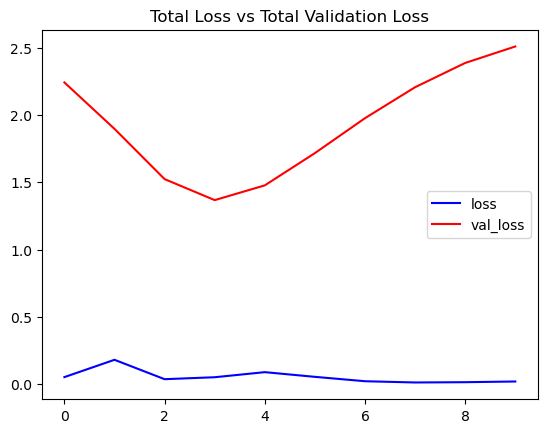

In [25]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

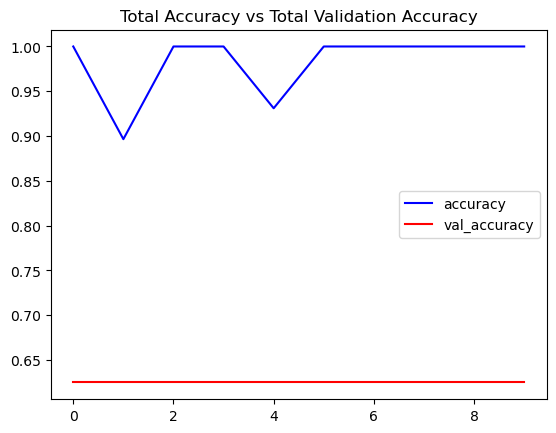

In [26]:
# Visualize the training and validation accuracy metrices.
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [15]:
import h5py

model.save('violence_detector.keras')

# Later, to load the model and make predictions:
loaded_model = keras.models.load_model('violence_detector.keras')

ImportError: DLL load failed while importing _errors: The specified procedure could not be found.